<a href="https://colab.research.google.com/github/John-G-Thomas/DS-Unit-4-Sprint-2-Neural-Networks/blob/main/module2-Train/LS_DS_432_Train_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 4, Sprint 2, Module 2*

---

# Train (Prepare)
__*Neural Network Foundations*__

## Learning Objectives
* <a href="#p1">Part 1</a>: Student should be able to explain the intuition behind backpropagation and gradient descent
* <a href="#p2">Part 2</a>: Student should be able to discuss the importance of batch size
* <a href="#p3">Part 3</a>: Student should be able to discuss the importance of learning rate

## Summary of Yesterday

Yesterday, we learned about some of the principal components of Neural Networks: Neurons, Weights, Activation Functions, and layers (input, output, & hidden). Today, we will reinforce our understanding of those components and introduce the mechanics of training a neural network. Feed-forward neural networks, such as multi-layer perceptrons (MLPs), are almost always trained using some variation of gradient descent where the gradient has been calculated by backpropagation.

  <center><img src="https://raw.githubusercontent.com/LambdaSchool/DS-Unit-4-Sprint-2-Neural-Networks/main/module1-Architect/IMG_0167.jpeg" width=400></center>

- There are three kinds of layers: input, hidden, and output layers.
- Each layer is made up of **n** individual neurons (aka activation units) which have a corresponding weight and bias.
- Signal is passed from layer to layer through a network by:
 - Taking in inputs from the training data (or previous layer)
 - Multiplying each input by its corresponding weight (think arrow/connecting line)
 - Adding a bias to this weighted some of inputs and weights
 - Activating this weighted sum + bias by squishifying it with sigmoid or some other activation function. With a single perceptron with three inputs, calculating the output from the node is done like so:
\begin{align}
 y = sigmoid(\sum(weight_{1}input_{1} + weight_{2}input_{2} + weight_{3}input_{3}) + bias)
\end{align}
 - this final activated value is the signal that gets passed onto the next layer of the network.
 

## Training a Neural Network: *Formal Summary*

0. Pick a network architecture
   - No. of input units = No. of features
   - No. of output units = Number of Classes (or expected targets)
   - Select the number of hidden layers and number of neurons within each hidden layer
1. Randomly initialize weights
2. Implement forward propagation to get $h_{\theta}(x^{(i)})$ for any $x^{(i)}$
3. Implement code to compute a cost function $J(\theta)$
4. Implement backpropagation to compute partial derivatives $\frac{\delta}{\delta\theta_{jk}^{l}}{J(\theta)}$
5. Use gradient descent (or other advanced optimizer) with backpropagation to minimize $J(\theta)$ as a function of parameters $\theta\$
6. Repeat steps 2 - 5 until cost function is 'minimized' or some other stopping criteria is met. One pass over steps 2 - 5 is called an iteration or epoch.

# Backpropagation & Gradient Descent (Learn)
<a id="p1"></a>

## Overview

Backpropagation is short for ["Backwards Propagation of errors"](https://en.wikipedia.org/wiki/Backpropagation) and refers to a specific (rather calculus intensive) algorithm for how weights in a neural network are updated in reverse order at the end of each training epoch. Our purpose today is to demonstrate the backpropagation algorithm on a simple Feedforward Neural Network and in so doing help you get a grasp on the main process. If you want to understand all of the underlying calculus of how the gradients are calculated then you'll need to dive into it yourself, [3Blue1Brown's video is a great starting place](https://www.youtube.com/watch?v=tIeHLnjs5U8). I also highly recommend this Welch Labs series [Neural Networks Demystified](https://www.youtube.com/watch?v=bxe2T-V8XRs) if you want a rapid yet orderly walk through of the main intuitions and math behind the backpropagation algorithm. 

### What is a Gradient?

> In vector calculus, the gradient is a multi-variable generalization of the derivative. 

The gradients that we will deal with today will be vector representations of the derivative of the activation function. 

## Follow Along

In this section, we will again a simple neural network using base TensorFlow. We'll focus on using a __Feed Forward Neural Network__ to predict test scores. 

<center><img src="https://raw.githubusercontent.com/LambdaSchool/DS-Unit-4-Sprint-2-Neural-Networks/main/module1-Architect/IMG_99C94113202D-1.jpeg"width=500></center>

### Generate some Fake Data

In [1]:
import tensorflow as tf

# Imagine that our data is drawn from a linear function
# y = 3*hours_studying + 50

TRUE_W = 3.5
TRUE_b = 50.0
NUM_EXAMPLES = 1000

inputs = tf.random.normal(shape=[NUM_EXAMPLES])
noise = tf.random.normal(shape=[NUM_EXAMPLES])

outputs = inputs * TRUE_W + TRUE_b + noise

In [2]:
inputs[:5]

<tf.Tensor: shape=(5,), dtype=float32, numpy=
array([-1.0055189,  1.2156343,  2.1703794, -1.0647036, -1.3138605],
      dtype=float32)>

In [3]:
noise[:5]

<tf.Tensor: shape=(5,), dtype=float32, numpy=
array([ 1.23979  , -1.0884901,  2.0237195,  1.0241058, -1.0814365],
      dtype=float32)>

In [4]:
outputs[:5]

<tf.Tensor: shape=(5,), dtype=float32, numpy=
array([47.720474, 53.16623 , 59.62005 , 47.29764 , 44.320053],
      dtype=float32)>

### Loss Function
Here we will use Mean Squared Error (MSE), because this is a regression problem. We are trying to predict a continuous target.

In [5]:
def loss(target_y, predicted_y):
  "MSE"
  return tf.reduce_mean(tf.square(target_y - predicted_y))

### Neural Network Architecture
Lets create a Neural Network class called "Model" to contain this functionality. Note: This is essentially a linear regression whose coefficients are trained by gradient descent. In practice, gradient descent works on much more complex function like the multi-layer networks we constructed yesterday.

In [6]:
class Model(object):

  def __init__(self):
    self.W = tf.Variable(8.0)
    self.b = tf.Variable(40.0)

  def __call__(self, x):
    return self.W * x + self.b

model = Model()

assert model(3.0).numpy() == 64.0

In [7]:
model(3.0).numpy()

64.0

### Initial Weights
The initial weights in our model were arbitrary. In practice, weights are initialized randomly. 

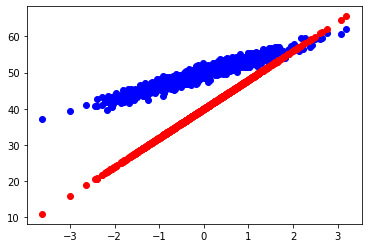

Current loss: 122.518166


In [8]:
import matplotlib.pyplot as plt

plt.scatter(inputs, outputs, c='b')
plt.scatter(inputs, model(inputs), c='r')
plt.show()

print('Current loss: %1.6f' % loss(model(inputs), outputs).numpy())

### Update Weights Based on Gradient

> *Assigning blame for bad predictions and delivering justice - repeatedly and a little bit at a time*

You should also know that with neural networks it is common to have gradients that are not convex (like what we saw when we applied gradient descent to linear regression). 

Due to the high complexity of these models and their nonlinearity, it is common for gradient descent to get stuck in a local minimum, but there are ways to combat this:

1) Stochastic Gradient Descent

2) More advanced Gradient-Descent-based "Optimizers" - See Stretch Goals on assignment.

In [9]:
 def train(model, inputs, outputs, learning_rate):
  with tf.GradientTape() as t: 
     current_loss = loss(outputs, model(inputs))
  dW, db = t.gradient(current_loss, [model.W, model.b])
  model.W.assign_sub(learning_rate * dW)
  model.b.assign_sub(learning_rate * db)

### Train the Network

In [10]:
model = Model()

# Store Some history of weights
Ws, bs = [], []
epochs = range(10)
for epoch in epochs:
  Ws.append(model.W.numpy())
  bs.append(model.b.numpy())
  current_loss = loss(outputs, model(inputs))

  train(model, inputs, outputs, learning_rate=0.1)
  print('Epoch %2d: W=%1.2f b=%1.2f loss=%2.5f' % (epoch, Ws[-1], bs[-1], current_loss))

Epoch  0: W=8.00 b=40.00 loss=122.51817
Epoch  1: W=7.07 b=42.02 loss=78.00892
Epoch  2: W=6.33 b=43.63 loss=49.79519
Epoch  3: W=5.74 b=44.92 loss=31.91057
Epoch  4: W=5.28 b=45.94 loss=20.57330
Epoch  5: W=4.91 b=46.75 loss=13.38632
Epoch  6: W=4.62 b=47.40 loss=8.83020
Epoch  7: W=4.39 b=47.92 loss=5.94184
Epoch  8: W=4.21 b=48.34 loss=4.11070
Epoch  9: W=4.06 b=48.67 loss=2.94977


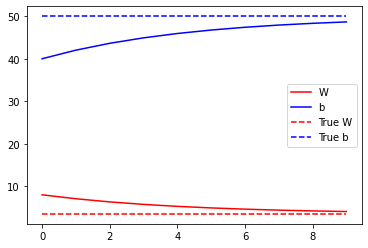

In [11]:
import matplotlib.pyplot as plt

plt.plot(epochs, Ws, 'r', epochs, bs, 'b')
plt.plot([TRUE_W] * len(epochs), 'r--',
         [TRUE_b] * len(epochs), 'b--')
plt.legend(['W', 'b', 'True W', 'True b'])
plt.show()

## Challenge

In the module project, you will be asked to explain the logic of backpropagation and gradient descent.

# Batch Size (Learn)

## Overview

The What - Stochastic Gradient Descent calculates an approximation of the gradient over the entire dataset by reviewing the predictions of a random sample. 

The Why - *Speed*. Calculating the gradient over the entire dataset is extremely expensive computationally. 

### Batch Size
Batches are the number of observations our model is shown to make predictions and update the weights. Batches are selected randomly during epoch. All observations are considered when passing thru an epoch at some point.

* Smaller Batch = Slower Run Time (but maybe more accurate results)
* Default Batch = Balance between speed and accuracy
* Large Batch = Very fast, but not nearly as accurate.

### Baseline Model

In [12]:
from tensorflow.keras.datasets import mnist

(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train / 255.
X_test = X_test / 255.

X_train = X_train.reshape((60000, 784))
X_test = X_test.reshape((10000, 784))

11493376/11490434 [==============================] - 0s 0us/step


In [13]:
# Our Model
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD

def create_model(lr=.01):
  opt = SGD(learning_rate=lr)

  model = Sequential(
      [
       Dense(32, activation='relu', input_dim=784),
       Dense(32, activation='relu'),
       Dense(10, activation='softmax')       
      ]
)
  model.compile(optimizer=opt, loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])
  return model

In [14]:
mnist_model = create_model()
dir(mnist_model)

['_TF_MODULE_IGNORED_PROPERTIES',
 '__call__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_activity_regularizer',
 '_add_trackable',
 '_add_variable_with_custom_getter',
 '_assert_compile_was_called',
 '_assert_weights_created',
 '_auto_track_sub_layers',
 '_autocast',
 '_autographed_call',
 '_base_model_initialized',
 '_build_graph_network_for_inferred_shape',
 '_build_input_shape',
 '_call_accepts_kwargs',
 '_call_arg_was_passed',
 '_call_fn_arg_defaults',
 '_call_fn_arg_positions',
 '_call_fn_args',
 '_call_full_argspec',
 '_callable_losses',
 '_cast_single_input',
 '_check_call_args',
 '_checkpoint_dependencies',
 '_clear_los

In [15]:
mnist_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                25120     
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_2 (Dense)              (None, 10)                330       
Total params: 26,506
Trainable params: 26,506
Non-trainable params: 0
_________________________________________________________________


In [16]:
32 * 784  # Pretty close to # of parameters, there's also bias etc.

25088

## Follow Along
Let's run a series of experiments for a default, small, and large batch size.

### Default
Batch Size is 32

In [17]:
mnist_model_32 = create_model()

bt_default = mnist_model_32.fit(X_train, y_train,
                                # Hyperparameters!
                                epochs=25,
                                batch_size=32,
                                validation_data=(X_test, y_test))

Epoch 1/25
1875/1875 [==============================] - 4s 2ms/step - loss: 0.7297 - accuracy: 0.8013 - val_loss: 0.3414 - val_accuracy: 0.9012
Epoch 2/25
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3225 - accuracy: 0.9070 - val_loss: 0.2873 - val_accuracy: 0.9171
Epoch 3/25
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2758 - accuracy: 0.9199 - val_loss: 0.2537 - val_accuracy: 0.9276
Epoch 4/25
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2449 - accuracy: 0.9286 - val_loss: 0.2308 - val_accuracy: 0.9319
Epoch 5/25
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2212 - accuracy: 0.9353 - val_loss: 0.2103 - val_accuracy: 0.9376
Epoch 6/25
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2021 - accuracy: 0.9404 - val_loss: 0.1981 - val_accuracy: 0.9405
Epoch 7/25
1875/1875 [==============================] - 4s 2ms/step - loss: 0.1870 - accuracy: 0.9457 - val_loss: 0.1843 - val_accuracy:

### Small Batch Size
Batch Size is 8

In [18]:
mnist_model_8 = create_model()

bt_small = mnist_model_8.fit(X_train, y_train,
                             # Hyperparameters!
                             epochs=25,
                             batch_size=8,
                             validation_data=(X_test, y_test))

Epoch 1/25
7500/7500 [==============================] - 15s 2ms/step - loss: 0.4301 - accuracy: 0.8757 - val_loss: 0.2580 - val_accuracy: 0.9231
Epoch 2/25
7500/7500 [==============================] - 15s 2ms/step - loss: 0.2167 - accuracy: 0.9373 - val_loss: 0.1767 - val_accuracy: 0.9492
Epoch 3/25
7500/7500 [==============================] - 15s 2ms/step - loss: 0.1703 - accuracy: 0.9505 - val_loss: 0.1551 - val_accuracy: 0.9535
Epoch 4/25
7500/7500 [==============================] - 15s 2ms/step - loss: 0.1433 - accuracy: 0.9579 - val_loss: 0.1531 - val_accuracy: 0.9532
Epoch 5/25
7500/7500 [==============================] - 15s 2ms/step - loss: 0.1261 - accuracy: 0.9630 - val_loss: 0.1460 - val_accuracy: 0.9528
Epoch 6/25
7500/7500 [==============================] - 14s 2ms/step - loss: 0.1132 - accuracy: 0.9655 - val_loss: 0.1297 - val_accuracy: 0.9603
Epoch 7/25
7500/7500 [==============================] - 15s 2ms/step - loss: 0.1039 - accuracy: 0.9689 - val_loss: 0.1147 - val_ac

### Large Batch Size
Batch Size is 512

In [19]:
mnist_model_512 = create_model()

bt_large = mnist_model_512.fit(X_train, y_train,
                               # Hyperparameters!
                               epochs=25,
                               batch_size=512,
                               validation_data=(X_test, y_test))

Epoch 1/25
118/118 [==============================] - 1s 4ms/step - loss: 2.1405 - accuracy: 0.2174 - val_loss: 1.9037 - val_accuracy: 0.4271
Epoch 2/25
118/118 [==============================] - 0s 3ms/step - loss: 1.6595 - accuracy: 0.5766 - val_loss: 1.3609 - val_accuracy: 0.6934
Epoch 3/25
118/118 [==============================] - 0s 3ms/step - loss: 1.1582 - accuracy: 0.7326 - val_loss: 0.9488 - val_accuracy: 0.7709
Epoch 4/25
118/118 [==============================] - 0s 3ms/step - loss: 0.8556 - accuracy: 0.7851 - val_loss: 0.7413 - val_accuracy: 0.8093
Epoch 5/25
118/118 [==============================] - 0s 3ms/step - loss: 0.6967 - accuracy: 0.8191 - val_loss: 0.6244 - val_accuracy: 0.8383
Epoch 6/25
118/118 [==============================] - 0s 3ms/step - loss: 0.6026 - accuracy: 0.8399 - val_loss: 0.5495 - val_accuracy: 0.8531
Epoch 7/25
118/118 [==============================] - 0s 3ms/step - loss: 0.5412 - accuracy: 0.8544 - val_loss: 0.5001 - val_accuracy: 0.8648
Epoch 

### Visualization of Results

In [20]:
import seaborn as sns
import pandas as pd

batch_sizes = []

for exp, result in zip([bt_default, bt_small, bt_large], ["32_", "8_", "512_"]):

  df = pd.DataFrame.from_dict(exp.history)
  df['epoch'] = df.index.values
  df['Batch Size'] = result

  batch_sizes.append(df)

df = pd.concat(batch_sizes)
df['Batch Size'] = df['Batch Size'].astype('str')
df.head()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


,loss,accuracy,val_loss,val_accuracy,epoch,Batch Size
0,0.729733,0.801317,0.341368,0.9012,0,32_
1,0.322466,0.907000,0.287259,0.9171,1,32_
2,0.275769,0.919933,0.253743,0.9276,2,32_
3,0.244877,0.928550,0.230831,0.9319,3,32_
4,0.221233,0.935317,0.210341,0.9376,4,32_


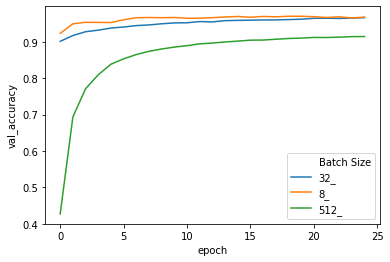

In [21]:
sns.lineplot(x='epoch', y='val_accuracy', hue='Batch Size', data=df);

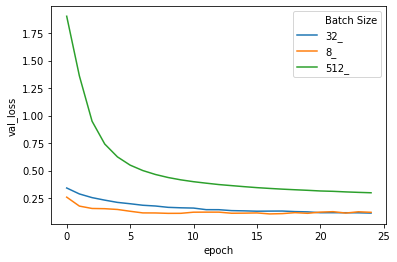

In [22]:
sns.lineplot(x='epoch', y='val_loss', hue='Batch Size', data=df);

## Challenge

You will be expected to experiment with batch size on today's assignment.

# Learning Rate (Learn)

## Overview

Learning Rate controls the size of the update to our weights that the optimization algorithm makes. VERY IMPORTANT hyperparameter.

* Too high of a learning rate causes unstable results
* Too Low of a learning rate the model will underfit
* Goldilocks parameters - it needs be "just right"
* Scale of 0-1

## Follow Along

Same experiment with Batch but different learning rates:
* High Learning = .75
* Default Learning = .01
* Low Learning Rate = .0001

### Default Learning Rate

In [23]:
# Running with 10 for time, feel free to rerun with 25 to make nicer plots
lr_default = create_model().fit(X_train, y_train,
                                epochs=10,
                                validation_data=(X_test,y_test)
)

Epoch 1/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.7401 - accuracy: 0.7877 - val_loss: 0.3612 - val_accuracy: 0.8979
Epoch 2/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3323 - accuracy: 0.9051 - val_loss: 0.2917 - val_accuracy: 0.9159
Epoch 3/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2817 - accuracy: 0.9183 - val_loss: 0.2544 - val_accuracy: 0.9252
Epoch 4/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2525 - accuracy: 0.9276 - val_loss: 0.2300 - val_accuracy: 0.9337
Epoch 5/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2297 - accuracy: 0.9335 - val_loss: 0.2162 - val_accuracy: 0.9359
Epoch 6/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2114 - accuracy: 0.9391 - val_loss: 0.1995 - val_accuracy: 0.9393
Epoch 7/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.1958 - accuracy: 0.9435 - val_loss: 0.1899 - val_accuracy:

### High Learning Rate

In [24]:
lr_high = create_model(lr=.75).fit(X_train, y_train,
                                epochs=10,
                                validation_data=(X_test,y_test)
)

Epoch 1/10
1875/1875 [==============================] - 4s 2ms/step - loss: 1.0775 - accuracy: 0.5746 - val_loss: 0.8065 - val_accuracy: 0.6471
Epoch 2/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.8245 - accuracy: 0.6728 - val_loss: 0.7219 - val_accuracy: 0.7186
Epoch 3/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.8334 - accuracy: 0.6843 - val_loss: 0.8711 - val_accuracy: 0.6516
Epoch 4/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.8252 - accuracy: 0.6908 - val_loss: 0.8510 - val_accuracy: 0.6845
Epoch 5/10
1875/1875 [==============================] - 4s 2ms/step - loss: 1.3915 - accuracy: 0.4562 - val_loss: 1.2570 - val_accuracy: 0.4677
Epoch 6/10
1875/1875 [==============================] - 4s 2ms/step - loss: 1.2786 - accuracy: 0.4766 - val_loss: 1.0914 - val_accuracy: 0.5264
Epoch 7/10
1875/1875 [==============================] - 4s 2ms/step - loss: 1.1332 - accuracy: 0.5211 - val_loss: 1.2503 - val_accuracy:

### Low Learning Rate

In [25]:
lr_low = create_model(lr=.0001).fit(X_train, y_train,
                                epochs=10,
                                validation_data=(X_test,y_test)
)

Epoch 1/10
1875/1875 [==============================] - 4s 2ms/step - loss: 2.2571 - accuracy: 0.1894 - val_loss: 2.2227 - val_accuracy: 0.2257
Epoch 2/10
1875/1875 [==============================] - 4s 2ms/step - loss: 2.1890 - accuracy: 0.2691 - val_loss: 2.1577 - val_accuracy: 0.3050
Epoch 3/10
1875/1875 [==============================] - 4s 2ms/step - loss: 2.1278 - accuracy: 0.3365 - val_loss: 2.0943 - val_accuracy: 0.3631
Epoch 4/10
1875/1875 [==============================] - 4s 2ms/step - loss: 2.0634 - accuracy: 0.3859 - val_loss: 2.0247 - val_accuracy: 0.4098
Epoch 5/10
1875/1875 [==============================] - 4s 2ms/step - loss: 1.9923 - accuracy: 0.4207 - val_loss: 1.9482 - val_accuracy: 0.4416
Epoch 6/10
1875/1875 [==============================] - 4s 2ms/step - loss: 1.9157 - accuracy: 0.4523 - val_loss: 1.8681 - val_accuracy: 0.4723
Epoch 7/10
1875/1875 [==============================] - 4s 2ms/step - loss: 1.8372 - accuracy: 0.4771 - val_loss: 1.7876 - val_accuracy:

### Visualization of Results

In [26]:
import seaborn as sns
import pandas as pd

batch_sizes = []

for exp, result in zip([lr_default, lr_low, lr_high], [".01_", ".0001_", ".75_"]):

  df = pd.DataFrame.from_dict(exp.history)
  df['epoch'] = df.index.values
  df['Learning Rate'] = result

  batch_sizes.append(df)

df = pd.concat(batch_sizes)
df['Learning Rate'] = df['Learning Rate'].astype('str')
df.head()

,loss,accuracy,val_loss,val_accuracy,epoch,Learning Rate
0,0.740085,0.787700,0.361168,0.8979,0,.01_
1,0.332284,0.905083,0.291703,0.9159,1,.01_
2,0.281723,0.918350,0.254444,0.9252,2,.01_
3,0.252508,0.927567,0.229985,0.9337,3,.01_
4,0.229695,0.933500,0.216217,0.9359,4,.01_


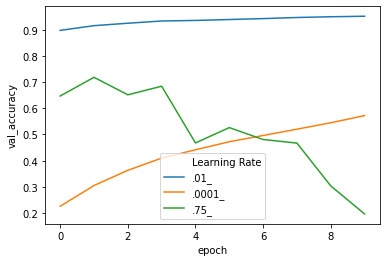

In [27]:
sns.lineplot(x='epoch', y='val_accuracy', hue='Learning Rate', data=df);

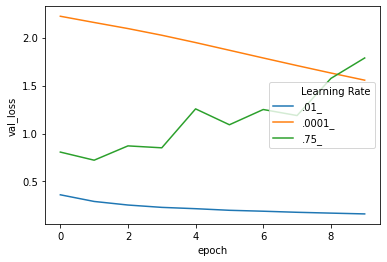

In [28]:
sns.lineplot(x='epoch', y='val_loss', hue='Learning Rate', data=df);

## Challenge

You will be expected to experiment with different learning rates today.

---